In [ ]:
!pip install tensorflow

import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np
import zipfile

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path tempat dataset diunduh di Google Drive
zip_path = "/content/drive/MyDrive/Colab Notebooks/data_face.zip"

In [ ]:
# Ekstrak dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/mask_classification")

In [ ]:
TRAINING_DIR = "/tmp/mask-classification/training"
VALIDATION_DIR = "/tmp/mask-classification/validation"

In [ ]:
# Fungsi untuk membagi data menjadi training dan validation, serta membuat generator data
def split_data_and_create_generators(TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    # Jika direktori training dan validation sudah ada, kosongkan isinya
    for directory in [TRAINING_DIR, VALIDATION_DIR]:
        if os.path.exists(directory):
            shutil.rmtree(directory)

    # Buat direktori training dan validation # Create the directories before trying to copy files into them.
    for directory in [TRAINING_DIR, VALIDATION_DIR]:
        os.makedirs(directory, exist_ok=True) # Added exist_ok=True to avoid errors if the directories already exist

    # List kategori pada dataset
    categories = ["with_mask", "without_mask"]

    # Bagi data ke dalam direktori training dan validation
    for category in categories:
        # Create subdirectories for each category within training and validation
        os.makedirs(os.path.join(TRAINING_DIR, category), exist_ok=True)
        os.makedirs(os.path.join(VALIDATION_DIR, category), exist_ok=True)

        category_path = os.path.join("/content/mask_classification/data_face", category)
        files = os.listdir(category_path)

        # Bagi data menjadi training dan validation
        split_index = int(len(files) * SPLIT_SIZE)
        training_files = files[:split_index]
        validation_files = files[split_index:]

        # Salin file ke direktori yang sesuai
        for file in training_files:
            src = os.path.join(category_path, file)
            dst = os.path.join(TRAINING_DIR, category, file)
            shutil.copyfile(src, dst)

        for file in validation_files:
            src = os.path.join(category_path, file)
            dst = os.path.join(VALIDATION_DIR, category, file)
            shutil.copyfile(src, dst)

        # Print jumlah data di setiap direktori
        print(f"Kategori {category}:")
        print(f"  - Jumlah data training: {len(training_files)}")
        print(f"  - Jumlah data validation: {len(validation_files)}")

    # Inisialisasi ImageDataGenerator untuk data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Memuat data dari direktori dan melakukan data augmentation
    batch_size = 32
    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_generator, validation_generator

# Call the function to create the generators
train_generator, validation_generator = split_data_and_create_generators(TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE=0.8) # Assuming a split of 80% for training

Kategori with_mask:
  - Jumlah data training: 392
  - Jumlah data validation: 99
Kategori without_mask:
  - Jumlah data training: 400
  - Jumlah data validation: 100
Found 792 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [ ]:
# Definisi model ANN
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6291584   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6291713 (24.00 MB)
Trainable params: 6291713 (24.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Melatih model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
25/25 [==============================] - 10s 367ms/step - loss: 6.8098 - accuracy: 0.5417 - val_loss: 2.9069 - val_accuracy: 0.5176
Epoch 2/15
25/25 [==============================] - 7s 266ms/step - loss: 0.9961 - accuracy: 0.7020 - val_loss: 0.3679 - val_accuracy: 0.9146
Epoch 3/15
25/25 [==============================] - 5s 205ms/step - loss: 0.5135 - accuracy: 0.7841 - val_loss: 0.3122 - val_accuracy: 0.8995
Epoch 4/15
25/25 [==============================] - 3s 135ms/step - loss: 0.4487 - accuracy: 0.7967 - val_loss: 0.3191 - val_accuracy: 0.9497
Epoch 5/15
25/25 [==============================] - 3s 132ms/step - loss: 0.3902 - accuracy: 0.8321 - val_loss: 0.2555 - val_accuracy: 0.9296
Epoch 6/15
25/25 [==============================] - 4s 166ms/step - loss: 0.3840 - accuracy: 0.8106 - val_loss: 0.2807 - val_accuracy: 0.9648
Epoch 7/15
25/25 [==============================] - 4s 161ms/step - loss: 0.3810 - accuracy: 0.8157 - val_loss: 0.1979 - val_accuracy: 0.9648
Epoch

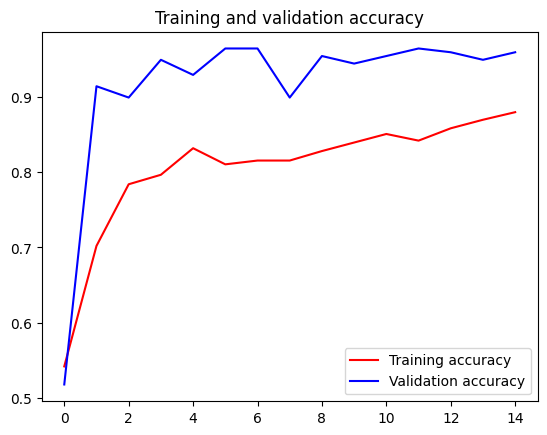

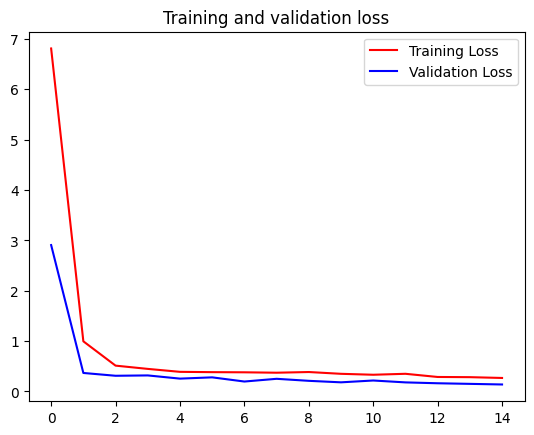

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from google.colab import files

Saving thv mask.jpg to thv mask.jpg
User uploaded file "thv mask.jpg"
1/1 [==============================] - 0s 17ms/step


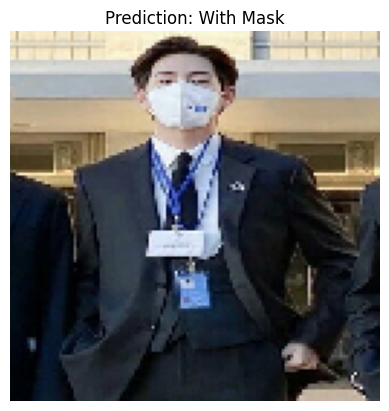

In [ ]:
# Fungsi untuk memprediksi gambar yang diupload dan menampilkan hasil
def predict_and_show_image(image_path, model):
    img = load_img(image_path, target_size=(128, 128)) # Change target size to 128x128
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    if prediction[0] >= 0.5:
        predicted_class = "Without Mask"
    else:
        predicted_class = "With Mask"

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

# Unggah dan prediksi gambar
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')
    predict_and_show_image(fn, model)